First let's load the Jar. This requires `mill q.assembly` to be run beforehand.

In [1]:
interp.load.cp(os.pwd/".."/"out"/"q"/"assembly.dest"/"out.jar")

We will load some boilerplate code for graphing as well.

In [2]:
import $file.makeplot

import $file.$

Now, all the imports...

In [3]:
import riscq._
import riscq.tester.qubic._
import riscq.soc.QubicSoc
import riscq.tester._
import spinal.core.sim._
import spinal.core._
import spinal.lib.bus.tilelink.sim._
import spinal.lib.bus.tilelink._
import spinal.lib.bus.amba4.axi.sim.Axi4Master
import riscq.tester.RvAssembler
import riscq.tester.QubicAssembler
import riscq.tester.ByteHelper
import riscq.soc.QubicPlugins
import QubicTestConfig._
import scala.collection.mutable.ArrayBuffer
import spinal.lib._
import riscq.soc.MemoryMapSoc
import riscq.tester.RvAssembler
import riscq.tester.mmsoc.MMSocDriver

import riscq._
import riscq.tester.qubic._
import riscq.soc.QubicSoc
import riscq.tester._
import spinal.core.sim._
import spinal.core._
import spinal.lib.bus.tilelink.sim._
import spinal.lib.bus.tilelink._
import spinal.lib.bus.amba4.axi.sim.Axi4Master
import riscq.tester.RvAssembler
import riscq.tester.QubicAssembler
import riscq.tester.ByteHelper
import riscq.soc.QubicPlugins
import QubicTestConfig._
import scala.collection.mutable.ArrayBuffer
import spinal.lib._
import riscq.soc.MemoryMapSoc
import riscq.tester.RvAssembler
import riscq.tester.mmsoc.MMSocDriver

Some Gaussian nonsense...

In [4]:
def gaussian(width: Int, sigmas: Double = 3.0): Seq[Double] = {
  val sigma = width.toDouble / (2.0 * sigmas)
  val vals = (0 until width).map { i =>
    val x = i - width.toDouble / 2.0
    scala.math.exp(-(x * x) / (2 * sigma * sigma))
  }
  return vals
}

defined function gaussian

First, let's copy over the existing QubicSOC test and collect some output. This skips hand-writing assembly for the moment.

In [5]:
val dac_output = ArrayBuffer[Double]()
val carrier_output = ArrayBuffer[Double]()
simConfig
    .compile{
      val dut = QubicSoc(
        qubitNum = 8,
        withVivado = false,
        withCocotb = false,
        withWhitebox = true,
        withTest = true
      )
      dut.pgs.map{_.io.simPublic()}
      dut.cgs.map{_.io.simPublic()}
      dut
    }
    .doSim { dut =>
      val driver = new Driver(dut)
      import driver._
      val rvAsm = new RvAssembler(128)
      import rvAsm._
      val qbAsm = new QubicAssembler()
      import qbAsm._

      init()

      val batchSize = 16
      val dataWidth = 16
      for (i <- 0 until 4) {
        val batch = List.tabulate(batchSize)((x : Int) => BigInt((5000 * gaussian(4 * batchSize)(i * batchSize + x)).toInt)).reverse
        val batchData = riscq.pulse.PGTestPulse.concat(batch, dataWidth)
        val dataStr = batch.map { x => ByteHelper.intToBinStr(x, dataWidth) }.reduce { _ ++ _ }
        tlDriver.putFullData(0, dut.pulseOffset + i * batchSize * dataWidth / 8, ByteHelper.fromBinStr(dataStr).reverse)
      }
      cd100m.waitRisingEdge()

      val startTime = 50
      val insts = List(
        setTime(0), // 0
        carrier(1 << (16 - 5), 0), // 1
        qbAsm.pulse(
          puop,
          start = startTime,
          addr = 0,
          duration = 4,
          phase = 0, // (1 << (puop.phaseWidth - 7)),
          freq = 0,
          amp = (1 << (puop.ampWidth - 1)) - 1
        ), // 2
        beq(0, 0, 0) // 3
      )
      loadIMem(0, insts)

      dut.riscq_rst #= true
      tick()
      dut.riscq_rst #= false

      tick(startTime+8)
      for (i <- 0 until 6) {
        logTime()
        logPcs()
        logDac(0)
        logCarrier(0)
        println("")
        val dac = dut.pgs(0).io.data
        val pulse = dac.payload.map { _.r.toDouble * (1 << 14) }.toList
        dac_output ++= pulse
        val carrier = dut.cgs(0).io.carrier
        val data = carrier.payload.map { _.r.toDouble * (1 << 14) }.toList
        carrier_output ++= data
        tick()
      }
    }

[Runtime] SpinalHDL dev    git head : bbe3c9911a233a5aa9672c70d237336385ab7dcc
[Runtime] JVM max memory : 3910.0MiB
[Runtime] Current date : 2025.04.05 03:38:55
[Progress] at 0.000 : Elaborate components
debug jumps: ArrayBuffer(toplevel/riscqArea_riscq/null)
########################1
debug hazard ctrlrange: Range 0 to 0
debug hazard ds: 0
!!!!!!!!!!!!!###########Range 0 until 2
!!!!!!!!!!!!!###########Range 0 until 2
[Progress] at 4.678 : Checks and transforms
[Progress] at 9.856 : Generate Verilog to ./simWorkspace/tmp/job_1
[Warning] toplevel/riscqArea_riscq/integer_RegFilePlugin_logic_regfile_fpga/asMem_ram : Mem[32*32 bits].readAsync can only be write first into Verilog
[Warning] toplevel/riscqArea_riscq/integer_RegFilePlugin_logic_regfile_fpga/asMem_ram : Mem[32*32 bits].readAsync can only be write first into Verilog
[Warning] toplevel/rbBusLogic_rbTlWa_logic_bridge/upsize_d_ctx/contexts : Mem[8*2 bits].readAsync can only be write first into Verilog
[Warning] toplevel/cd100mLogic

dac_output: ArrayBuffer[Double] = ArrayBuffer(
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  53.0,
  70.0,
  86.0,
  102.0,
  111.0,
  112.0,
  97.0,
  62.0,
  0.0,
  -96.0,
  -228.0,
  -399.0,
  -609.0,
  -850.0,
  -1111.0,
  -1377.0,
  -1622.0,
  -1824.0,
  -1952.0,
  -1978.0,
  -1877.0,
  -1632.0,
...
carrier_output: ArrayBuffer[Double] = ArrayBuffer(
  -16383.0,
  -16068.0,
  -15136.0,
  -13622.0,
  -11584.0,
  -9102.0,
  -6269.0,
  -3196.0,
  0.0,
  3197.0,
  6270.0,
  9103.0,
  11585.0,
  13623.0,
  15137.0,
  16069.0,
  16382.0,
  16067.0,
  15135.0,
  13621.0,
  11583.0,
  9101.0,
  6268.0,
  3195.0,
  0.0,
  -3197.0,
  -6270.0,
  -9103.0,
  -11585.0,
  -13623.0,
  -15137.0,
  -16069.0,
  -16383.0,
  -16068.0,
  -15136.0,
  -13622.0,
  -11584.0,
  -9102.0,
...

Now, let's graph the DAC and Carrier data.

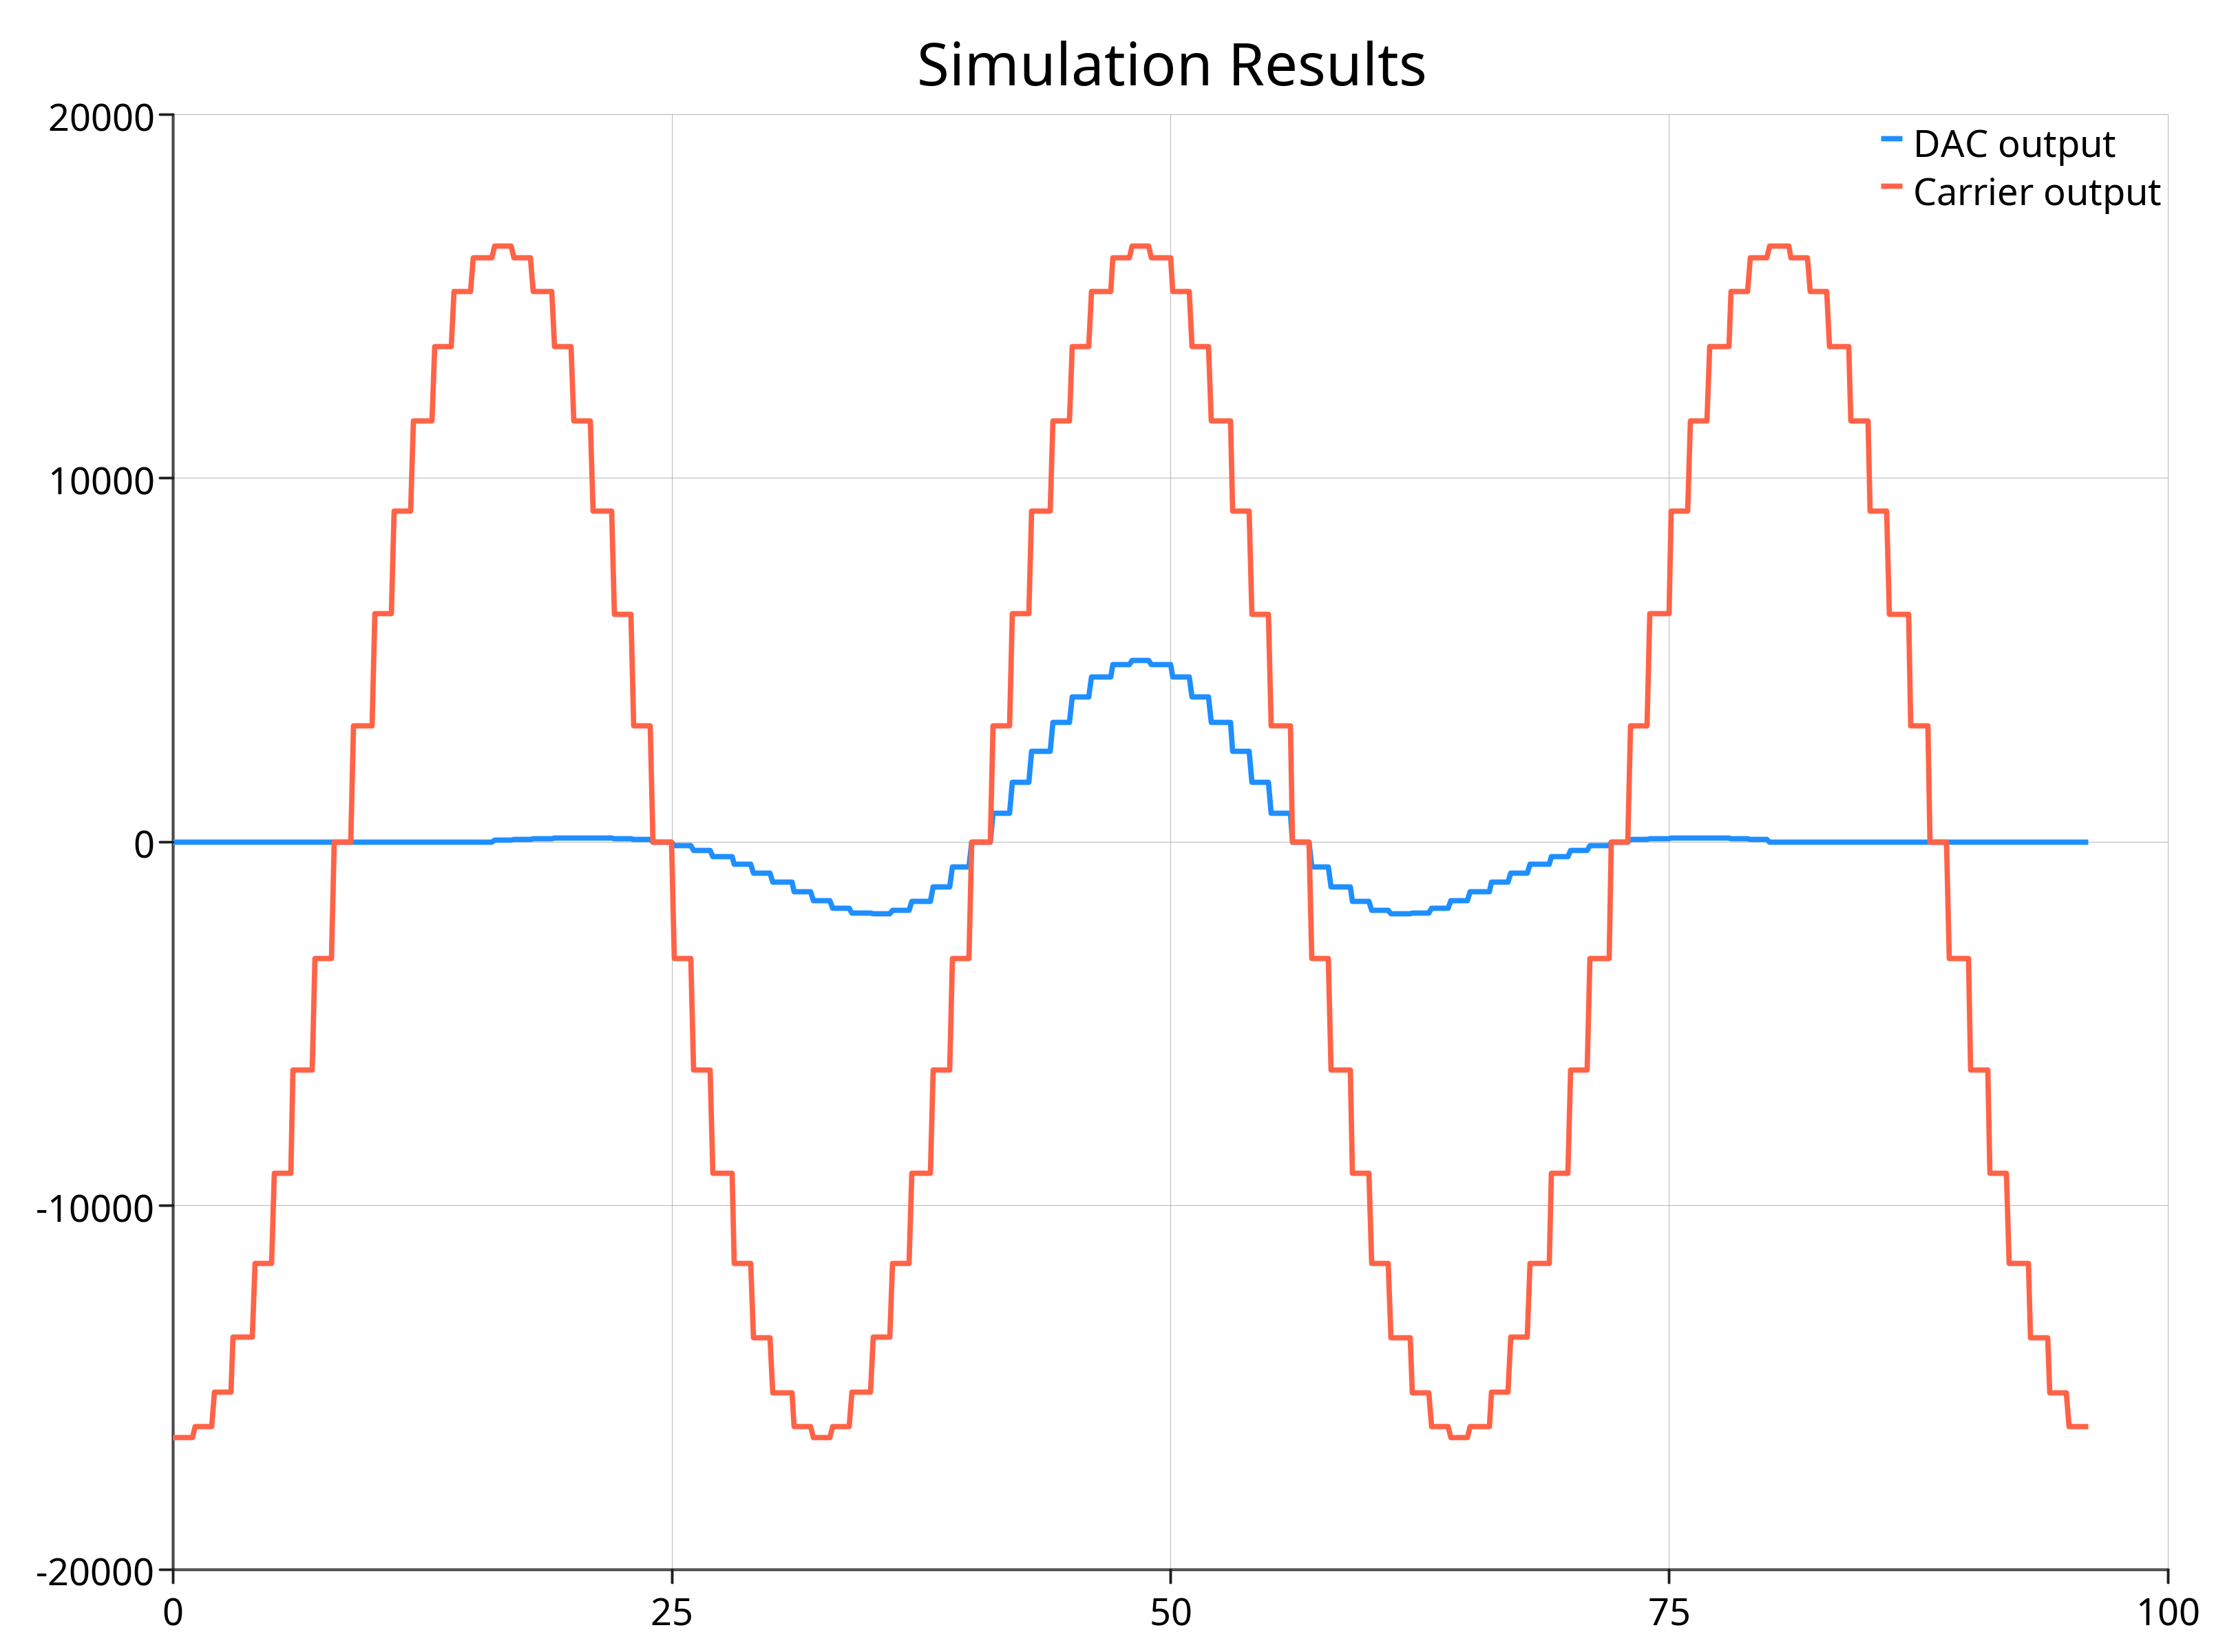

pngBytes: Array[Byte] = Array(
  -119,
  80,
  78,
  71,
  13,
  10,
  26,
  10,
  0,
  0,
  0,
  13,
  73,
  72,
  68,
  82,
  0,
  0,
  12,
  -80,
  0,
  0,
  9,
  96,
  8,
  6,
  0,
  0,
  0,
  34,
  11,
  47,
  101,
  0,
  0,
  -128,
  0,
  73,
...

In [6]:
val pngBytes = makeplot.make_plot(List(makeplot.LabeledData("DAC output", dac_output), makeplot.LabeledData("Carrier output", carrier_output)))
Image(pngBytes)